In [59]:
# Please run the command before running this code to generate inception (inside ./AttnGAN/code directory)
# !python main.py --cfg cfg/eval_CelebA.yml --gpu 0

Traceback (most recent call last):
  File "main.py", line 3, in <module>
    from miscc.config import cfg, cfg_from_file
  File "/home/ubuntu/11785/project/11785-Text-to-Sketch/AttnGAN/code/miscc/config.py", line 6, in <module>
    from easydict import EasyDict as edict
ModuleNotFoundError: No module named 'easydict'


# Inception Score / FID Score for ShangHai CelebA Sketch dataset

In [338]:
from IPython.display import Image
from os import listdir
from os.path import isfile, join
import numpy as np

orig_img_path = "../data/CelebA/sketches/"

# image_path = "../models/netG_epoch_34/example_captions"
all_imgg2s = []
num_folders = 200
for i in range(num_folders):
    image_path = "../models/netG_epoch_34/captions_{}/".format(i)
    images = [f for f in listdir(image_path) if isfile(join(image_path, f))]
    
    imga0 = [image_path + f for f in images if f[-6:-4] == "a0"]
    imga1 = [image_path + f for f in images if f[-6:-4] == "a1"]
    imgg0 = [image_path + f for f in images if f[-6:-4] == "g0"]
    imgg1 = [image_path + f for f in images if f[-6:-4] == "g1"]
    imgg2 = [image_path + f for f in images if f[-6:-4] == "g2"]
    
    all_imgg2s += imgg2

# imga0 = ["0_s_0_a0.png", "0_s_1_a0.png", "0_s_2_a0.png", "0_s_3_a0.png", "0_s_4_a0.png", "0_s_5_a0.png"]
# imga1 = ["0_s_0_a1.png", "0_s_1_a1.png", "0_s_2_a1.png", "0_s_3_a1.png", "0_s_4_a1.png", "0_s_5_a1.png"]
# imgg0 = ["0_s_0_g0.png", "0_s_1_g0.png", "0_s_2_g0.png", "0_s_3_g0.png", "0_s_4_g0.png", "0_s_5_g0.png"]
# imgg1 = ["0_s_0_g1.png", "0_s_1_g1.png", "0_s_2_g1.png", "0_s_3_g1.png", "0_s_4_g1.png", "0_s_5_g1.png"]
# imgg2 = ["0_s_0_g2.png", "0_s_1_g2.png", "0_s_2_g2.png", "0_s_3_g2.png", "0_s_4_g2.png", "0_s_5_g2.png"]

# Image(filename = img_path + imga0[0])
Image(filename = imga0[0])

# all_imgg2s = [np.random.uniform(low=0.0, high=1.0, size=(224,224,3)) for i in range(200)]
all_orig_imgs = [orig_img_path + f for f in listdir(orig_img_path) if isfile(join(orig_img_path, f))]
print(len(all_orig_imgs))
print(len(all_imgg2s))

200
200


The following code was based off of the copyright below.

https://github.com/sbarratt/inception-score-pytorch/blob/master/inception_score.py

Copyright 2017 Shane T. Barratt

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

In [344]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data

from torchvision.models.inception import inception_v3

import numpy as np
from scipy.stats import entropy

from PIL import Image
import cv2


def inception_score(imgs, cuda=True, batch_size=32, resize=False, splits=1):
    """Computes the inception score of the generated images imgs
    imgs -- Torch dataset of (3xHxW) numpy images normalized in the range [-1, 1]
    cuda -- whether or not to run on GPU
    batch_size -- batch size for feeding into Inception v3
    splits -- number of splits
    """
    N = len(imgs)

    assert batch_size > 0
    assert N > batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        if torch.cuda.is_available():
            print("WARNING: You have a CUDA device, so you should probably set cuda=True")
        dtype = torch.FloatTensor

    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # Load inception model
    inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval();
    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)
    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))
    
    return np.mean(split_scores), np.std(split_scores)

if __name__ == '__main__':
    class IgnoreLabelDataset(torch.utils.data.Dataset):
        def __init__(self, orig):
            self.orig = orig

        def __getitem__(self, index):
            path = self.orig[index]
            imgr = cv2.imread(path)
#             imgr = self.orig[index]
            imgr = cv2.resize(imgr,dsize=(224,224))
            img = transforms.ToTensor()(imgr)
            
            return img

        def __len__(self):
            return len(self.orig)

#     import torchvision.datasets as dset
#     import torchvision.transforms as transforms

#     cifar = dset.CIFAR10(root='data/', download=True,
#                              transform=transforms.Compose([
#                                  transforms.Scale(32),
#                                  transforms.ToTensor(),
#                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#                              ])
#     )
    
    dataset = IgnoreLabelDataset(all_imgg2s)
    
    print ("Calculating Inception Score...")
#     print (inception_score(IgnoreLabelDataset(cifar), cuda=True, batch_size=32, resize=True, splits=10))
    print (inception_score(dataset, cuda=True, batch_size=2, resize=True, splits=10))

Calculating Inception Score...


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


(1.3376242105985325, 0.11704306572950698)


https://github.com/hukkelas/pytorch-frechet-inception-distance/blob/master/fid.py

The following code was based off of the github repository stated above.

Apache License 2.0

In [346]:
import torch
from torch import nn
from torchvision.models import inception_v3
import cv2
import multiprocessing
import numpy as np
import glob
import os
from scipy import linalg


def to_cuda(elements):
    """
    Transfers elements to cuda if GPU is available
    Args:
        elements: torch.tensor or torch.nn.module
        --
    Returns:
        elements: same as input on GPU memory, if available
    """
    if torch.cuda.is_available():
        return elements.cuda()
    return elements


class PartialInceptionNetwork(nn.Module):

    def __init__(self, transform_input=True):
        super().__init__()
        self.inception_network = inception_v3(pretrained=True)
        self.inception_network.Mixed_7c.register_forward_hook(self.output_hook)
        self.transform_input = transform_input

    def output_hook(self, module, input, output):
        # N x 2048 x 8 x 8
        self.mixed_7c_output = output

    def forward(self, x):
        """
        Args:
            x: shape (N, 3, 299, 299) dtype: torch.float32 in range 0-1
        Returns:
            inception activations: torch.tensor, shape: (N, 2048), dtype: torch.float32
        """
        assert x.shape[1:] == (3, 299, 299), "Expected input shape to be: (N,3,299,299)" +\
                                             ", but got {}".format(x.shape)
        x = x * 2 -1 # Normalize to [-1, 1]

        # Trigger output hook
        self.inception_network(x)

        # Output: N x 2048 x 1 x 1 
        activations = self.mixed_7c_output
        activations = torch.nn.functional.adaptive_avg_pool2d(activations, (1,1))
        activations = activations.view(x.shape[0], 2048)
        return activations


def get_activations(images, batch_size):
    """
    Calculates activations for last pool layer for all iamges
    --
        Images: torch.array shape: (N, 3, 299, 299), dtype: torch.float32
        batch size: batch size used for inception network
    --
    Returns: np array shape: (N, 2048), dtype: np.float32
    """
    assert images.shape[1:] == (3, 299, 299), "Expected input shape to be: (N,3,299,299)" +\
                                              ", but got {}".format(images.shape)

    num_images = images.shape[0]
    inception_network = PartialInceptionNetwork()
    inception_network = to_cuda(inception_network)
    inception_network.eval()
    n_batches = int(np.ceil(num_images  / batch_size))
    inception_activations = np.zeros((num_images, 2048), dtype=np.float32)
    for batch_idx in range(n_batches):
        start_idx = batch_size * batch_idx
        end_idx = batch_size * (batch_idx + 1)

        ims = images[start_idx:end_idx]
        ims = to_cuda(ims)
        activations = inception_network(ims)
        activations = activations.detach().cpu().numpy()
        assert activations.shape == (ims.shape[0], 2048), "Expexted output shape to be: {}, but was: {}".format((ims.shape[0], 2048), activations.shape)
        inception_activations[start_idx:end_idx, :] = activations
    return inception_activations



def calculate_activation_statistics(images, batch_size):
    """Calculates the statistics used by FID
    Args:
        images: torch.tensor, shape: (N, 3, H, W), dtype: torch.float32 in range 0 - 1
        batch_size: batch size to use to calculate inception scores
    Returns:
        mu:     mean over all activations from the last pool layer of the inception model
        sigma:  covariance matrix over all activations from the last pool layer 
                of the inception model.
    """
    act = get_activations(images, batch_size)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma


# Modified from: https://github.com/bioinf-jku/TTUR/blob/master/fid.py
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
            
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1 : Numpy array containing the activations of the pool_3 layer of the
             inception net ( like returned by the function 'get_predictions')
             for generated samples.
    -- mu2   : The sample mean over activations of the pool_3 layer, precalcualted
               on an representive data set.
    -- sigma1: The covariance matrix over activations of the pool_3 layer for
               generated samples.
    -- sigma2: The covariance matrix over activations of the pool_3 layer,
               precalcualted on an representive data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
    assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"

    diff = mu1 - mu2
    # product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = "fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps
        warnings.warn(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean


def preprocess_image(im):
    """Resizes and shifts the dynamic range of image to 0-1
    Args:
        im: np.array, shape: (H, W, 3), dtype: float32 between 0-1 or np.uint8
    Return:
        im: torch.tensor, shape: (3, 299, 299), dtype: torch.float32 between 0-1
    """
    assert im.shape[2] == 3
    assert len(im.shape) == 3
    if im.dtype == np.uint8:
        im = im.astype(np.float32) / 255
    im = cv2.resize(im, (299, 299))
    im = np.rollaxis(im, axis=2)
    im = torch.from_numpy(im)
    assert im.max() <= 1.0
    assert im.min() >= 0.0
    assert im.dtype == torch.float32
    assert im.shape == (3, 299, 299)

    return im


def preprocess_images(images, use_multiprocessing):
    """Resizes and shifts the dynamic range of image to 0-1
    Args:
        images: np.array, shape: (N, H, W, 3), dtype: float32 between 0-1 or np.uint8
        use_multiprocessing: If multiprocessing should be used to pre-process the images
    Return:
        final_images: torch.tensor, shape: (N, 3, 299, 299), dtype: torch.float32 between 0-1
    """
    if use_multiprocessing:
        with multiprocessing.Pool(multiprocessing.cpu_count()) as pool:
            jobs = []
            for im in images:
                job = pool.apply_async(preprocess_image, (im,))
                jobs.append(job)
            final_images = torch.zeros(images.shape[0], 3, 299, 299)
            for idx, job in enumerate(jobs):
                im = job.get()
                final_images[idx] = im#job.get()
    else:
        final_images = torch.stack([preprocess_image(im) for im in images], dim=0)
    assert final_images.shape == (images.shape[0], 3, 299, 299)
    assert final_images.max() <= 1.0
    assert final_images.min() >= 0.0
    assert final_images.dtype == torch.float32
    return final_images


def calculate_fid(images1, images2, use_multiprocessing, batch_size):
    """ Calculate FID between images1 and images2
    Args:
        images1: np.array, shape: (N, H, W, 3), dtype: np.float32 between 0-1 or np.uint8
        images2: np.array, shape: (N, H, W, 3), dtype: np.float32 between 0-1 or np.uint8
        use_multiprocessing: If multiprocessing should be used to pre-process the images
        batch size: batch size used for inception network
    Returns:
        FID (scalar)
    """
    images1 = preprocess_images(images1, use_multiprocessing)
    images2 = preprocess_images(images2, use_multiprocessing)
    mu1, sigma1 = calculate_activation_statistics(images1, batch_size)
    mu2, sigma2 = calculate_activation_statistics(images2, batch_size)
    fid = calculate_frechet_distance(mu1, sigma1, mu2, sigma2)
    return fid


def load_images(path, gen = False):
    """ Loads all .png or .jpg images from a given path
    Warnings: Expects all images to be of same dtype and shape.
    Args:
        path: relative path to directory
    Returns:
        final_images: np.array of image dtype and shape.
    """
    image_paths = []
    image_extensions = ["png", "jpg"]
    for ext in image_extensions:
        print("Looking for images in", os.path.join(path, "*.{}".format(ext)))
        for impath in glob.glob(os.path.join(path, "*.{}".format(ext))):
            if not gen:
                image_paths.append(impath)
            else:
                if "g2" in impath:
                    image_paths.append(impath)
                    
    first_image = cv2.imread(image_paths[0])
    W = 256
    H = 256
    image_paths.sort()
    image_paths = image_paths
    final_images = np.zeros((len(image_paths), H, W, 3), dtype=first_image.dtype)
    for idx, impath in enumerate(image_paths):
        im = cv2.imread(impath)
        im = im[:, :, ::-1] # Convert from BGR to RGB
        assert im.dtype == final_images.dtype
        im = cv2.resize(im,dsize=(H,W))
        final_images[idx] = im
    return final_images


if __name__ == "__main__":
#     from optparse import OptionParser
#     parser = OptionParser()
#     parser.add_option("--p1", "--path1", dest="path1", 
#                       help="Path to directory containing the real images")
#     parser.add_option("--p2", "--path2", dest="path2", 
#                       help="Path to directory containing the generated images")
#     parser.add_option("--multiprocessing", dest="use_multiprocessing",
#                       help="Toggle use of multiprocessing for image pre-processing. Defaults to use all cores",
#                       default=False,
#                       action="store_true")
#     parser.add_option("-b", "--batch-size", dest="batch_size",
#                       help="Set batch size to use for InceptionV3 network",
#                       type=int)
    
#     options, _ = parser.parse_args()
#     assert options.path1 is not None, "--path1 is an required option"
#     assert options.path2 is not None, "--path2 is an required option"
#     assert options.batch_size is not None, "--batch_size is an required option"
#     images1 = load_images(options.path1)
#     images2 = load_images(options.path2)
#     fid_value = calculate_fid(images1, images2, options.use_multiprocessing, options.batch_size)
#     print(fid_value)

    orig_imgs = load_images(orig_img_path)
    num_folders = 200
    generated_imgs = []
    print(orig_imgs.shape)
    for i in range(num_folders):
        image_path = "../models/netG_epoch_34/captions_{}/".format(i)
        generated_imgs.append(load_images(image_path, True))
    generated_imgs = np.concatenate(generated_imgs)
#     generated_imgs = np.random.uniform(low=0, high=255, size=(200, 256, 256,3)).astype('uint8')
    print(generated_imgs.shape)
    
    
#     fid_value = calculate_fid(orig_imgs, generated_imgs, options.use_multiprocessing, options.batch_size)
    fid_value = calculate_fid(orig_imgs, generated_imgs, False, 8)
    print(fid_value)

Looking for images in ../data/CelebA/sketches/*.png
Looking for images in ../data/CelebA/sketches/*.jpg
(200, 256, 256, 3)
Looking for images in ../models/netG_epoch_34/captions_0/*.png
Looking for images in ../models/netG_epoch_34/captions_0/*.jpg
Looking for images in ../models/netG_epoch_34/captions_1/*.png
Looking for images in ../models/netG_epoch_34/captions_1/*.jpg
Looking for images in ../models/netG_epoch_34/captions_2/*.png
Looking for images in ../models/netG_epoch_34/captions_2/*.jpg
Looking for images in ../models/netG_epoch_34/captions_3/*.png
Looking for images in ../models/netG_epoch_34/captions_3/*.jpg
Looking for images in ../models/netG_epoch_34/captions_4/*.png
Looking for images in ../models/netG_epoch_34/captions_4/*.jpg
Looking for images in ../models/netG_epoch_34/captions_5/*.png
Looking for images in ../models/netG_epoch_34/captions_5/*.jpg
Looking for images in ../models/netG_epoch_34/captions_6/*.png
Looking for images in ../models/netG_epoch_34/captions_6/*

Looking for images in ../models/netG_epoch_34/captions_91/*.png
Looking for images in ../models/netG_epoch_34/captions_91/*.jpg
Looking for images in ../models/netG_epoch_34/captions_92/*.png
Looking for images in ../models/netG_epoch_34/captions_92/*.jpg
Looking for images in ../models/netG_epoch_34/captions_93/*.png
Looking for images in ../models/netG_epoch_34/captions_93/*.jpg
Looking for images in ../models/netG_epoch_34/captions_94/*.png
Looking for images in ../models/netG_epoch_34/captions_94/*.jpg
Looking for images in ../models/netG_epoch_34/captions_95/*.png
Looking for images in ../models/netG_epoch_34/captions_95/*.jpg
Looking for images in ../models/netG_epoch_34/captions_96/*.png
Looking for images in ../models/netG_epoch_34/captions_96/*.jpg
Looking for images in ../models/netG_epoch_34/captions_97/*.png
Looking for images in ../models/netG_epoch_34/captions_97/*.jpg
Looking for images in ../models/netG_epoch_34/captions_98/*.png
Looking for images in ../models/netG_epo

Looking for images in ../models/netG_epoch_34/captions_185/*.jpg
Looking for images in ../models/netG_epoch_34/captions_186/*.png
Looking for images in ../models/netG_epoch_34/captions_186/*.jpg
Looking for images in ../models/netG_epoch_34/captions_187/*.png
Looking for images in ../models/netG_epoch_34/captions_187/*.jpg
Looking for images in ../models/netG_epoch_34/captions_188/*.png
Looking for images in ../models/netG_epoch_34/captions_188/*.jpg
Looking for images in ../models/netG_epoch_34/captions_189/*.png
Looking for images in ../models/netG_epoch_34/captions_189/*.jpg
Looking for images in ../models/netG_epoch_34/captions_190/*.png
Looking for images in ../models/netG_epoch_34/captions_190/*.jpg
Looking for images in ../models/netG_epoch_34/captions_191/*.png
Looking for images in ../models/netG_epoch_34/captions_191/*.jpg
Looking for images in ../models/netG_epoch_34/captions_192/*.png
Looking for images in ../models/netG_epoch_34/captions_192/*.jpg
Looking for images in ../

# Inception Score / FID Score for test dataset

In [349]:
from IPython.display import Image
from os import listdir
from os.path import isfile, join
import numpy as np

orig_img_path = "../data/CelebA/images/"
test = np.load("../data/CelebA/test/filenames.pickle", allow_pickle = True)
print(type(test))
print(len(test))
test = np.array(test[:200]).astype(str)
gen_img_path = "../models/netG_epoch_34/"
all_imgg2s = []

for test_dir in test:
    img_path = gen_img_path + test_dir
#     images = [f for f in listdir(img_path) if isfile(join(img_path, f))]
    imgg2 = [img_path + "/0_s_9_g2.png"]
    all_imgg2s += imgg2

# imga0 = ["0_s_0_a0.png", "0_s_1_a0.png", "0_s_2_a0.png", "0_s_3_a0.png", "0_s_4_a0.png", "0_s_5_a0.png"]
# imga1 = ["0_s_0_a1.png", "0_s_1_a1.png", "0_s_2_a1.png", "0_s_3_a1.png", "0_s_4_a1.png", "0_s_5_a1.png"]
# imgg0 = ["0_s_0_g0.png", "0_s_1_g0.png", "0_s_2_g0.png", "0_s_3_g0.png", "0_s_4_g0.png", "0_s_5_g0.png"]
# imgg1 = ["0_s_0_g1.png", "0_s_1_g1.png", "0_s_2_g1.png", "0_s_3_g1.png", "0_s_4_g1.png", "0_s_5_g1.png"]
# imgg2 = ["0_s_0_g2.png", "0_s_1_g2.png", "0_s_2_g2.png", "0_s_3_g2.png", "0_s_4_g2.png", "0_s_5_g2.png"]

# Image(filename = img_path + imga0[0])

# all_imgg2s = [np.random.uniform(low=0.0, high=1.0, size=(224,224,3)) for i in range(200)]
all_orig_imgs = [orig_img_path + f + "_fake.png" for f in test ]
print(len(all_orig_imgs))
print(len(all_imgg2s))

<class 'list'>
39829
200
200


In [350]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data

from torchvision.models.inception import inception_v3

import numpy as np
from scipy.stats import entropy

from PIL import Image
import cv2


def inception_score(imgs, cuda=True, batch_size=32, resize=False, splits=1):
    """Computes the inception score of the generated images imgs
    imgs -- Torch dataset of (3xHxW) numpy images normalized in the range [-1, 1]
    cuda -- whether or not to run on GPU
    batch_size -- batch size for feeding into Inception v3
    splits -- number of splits
    """
    N = len(imgs)

    assert batch_size > 0
    assert N > batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        if torch.cuda.is_available():
            print("WARNING: You have a CUDA device, so you should probably set cuda=True")
        dtype = torch.FloatTensor

    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # Load inception model
    inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval();
    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)
    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))
    
    return np.mean(split_scores), np.std(split_scores)

if __name__ == '__main__':
    class IgnoreLabelDataset(torch.utils.data.Dataset):
        def __init__(self, orig):
            self.orig = orig

        def __getitem__(self, index):
            path = self.orig[index]
            imgr = cv2.imread(path)
#             imgr = self.orig[index]
            imgr = cv2.resize(imgr,dsize=(224,224))
            img = transforms.ToTensor()(imgr)
            
            return img

        def __len__(self):
            return len(self.orig)

#     import torchvision.datasets as dset
#     import torchvision.transforms as transforms

#     cifar = dset.CIFAR10(root='data/', download=True,
#                              transform=transforms.Compose([
#                                  transforms.Scale(32),
#                                  transforms.ToTensor(),
#                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#                              ])
#     )
    
    dataset = IgnoreLabelDataset(all_imgg2s)
    
    print ("Calculating Inception Score...")
#     print (inception_score(IgnoreLabelDataset(cifar), cuda=True, batch_size=32, resize=True, splits=10))
    print (inception_score(dataset, cuda=True, batch_size=2, resize=True, splits=10))


Calculating Inception Score...


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


(1.8675848891087223, 0.19568610524514796)


In [351]:
import torch
from torch import nn
from torchvision.models import inception_v3
import cv2
import multiprocessing
import numpy as np
import glob
import os
from scipy import linalg


def to_cuda(elements):
    """
    Transfers elements to cuda if GPU is available
    Args:
        elements: torch.tensor or torch.nn.module
        --
    Returns:
        elements: same as input on GPU memory, if available
    """
    if torch.cuda.is_available():
        return elements.cuda()
    return elements


class PartialInceptionNetwork(nn.Module):

    def __init__(self, transform_input=True):
        super().__init__()
        self.inception_network = inception_v3(pretrained=True)
        self.inception_network.Mixed_7c.register_forward_hook(self.output_hook)
        self.transform_input = transform_input

    def output_hook(self, module, input, output):
        # N x 2048 x 8 x 8
        self.mixed_7c_output = output

    def forward(self, x):
        """
        Args:
            x: shape (N, 3, 299, 299) dtype: torch.float32 in range 0-1
        Returns:
            inception activations: torch.tensor, shape: (N, 2048), dtype: torch.float32
        """
        assert x.shape[1:] == (3, 299, 299), "Expected input shape to be: (N,3,299,299)" +\
                                             ", but got {}".format(x.shape)
        x = x * 2 -1 # Normalize to [-1, 1]

        # Trigger output hook
        self.inception_network(x)

        # Output: N x 2048 x 1 x 1 
        activations = self.mixed_7c_output
        activations = torch.nn.functional.adaptive_avg_pool2d(activations, (1,1))
        activations = activations.view(x.shape[0], 2048)
        return activations


def get_activations(images, batch_size):
    """
    Calculates activations for last pool layer for all iamges
    --
        Images: torch.array shape: (N, 3, 299, 299), dtype: torch.float32
        batch size: batch size used for inception network
    --
    Returns: np array shape: (N, 2048), dtype: np.float32
    """
    assert images.shape[1:] == (3, 299, 299), "Expected input shape to be: (N,3,299,299)" +\
                                              ", but got {}".format(images.shape)

    num_images = images.shape[0]
    inception_network = PartialInceptionNetwork()
    inception_network = to_cuda(inception_network)
    inception_network.eval()
    n_batches = int(np.ceil(num_images  / batch_size))
    inception_activations = np.zeros((num_images, 2048), dtype=np.float32)
    for batch_idx in range(n_batches):
        start_idx = batch_size * batch_idx
        end_idx = batch_size * (batch_idx + 1)

        ims = images[start_idx:end_idx]
        ims = to_cuda(ims)
        activations = inception_network(ims)
        activations = activations.detach().cpu().numpy()
        assert activations.shape == (ims.shape[0], 2048), "Expexted output shape to be: {}, but was: {}".format((ims.shape[0], 2048), activations.shape)
        inception_activations[start_idx:end_idx, :] = activations
    return inception_activations



def calculate_activation_statistics(images, batch_size):
    """Calculates the statistics used by FID
    Args:
        images: torch.tensor, shape: (N, 3, H, W), dtype: torch.float32 in range 0 - 1
        batch_size: batch size to use to calculate inception scores
    Returns:
        mu:     mean over all activations from the last pool layer of the inception model
        sigma:  covariance matrix over all activations from the last pool layer 
                of the inception model.
    """
    act = get_activations(images, batch_size)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma


# Modified from: https://github.com/bioinf-jku/TTUR/blob/master/fid.py
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
            
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1 : Numpy array containing the activations of the pool_3 layer of the
             inception net ( like returned by the function 'get_predictions')
             for generated samples.
    -- mu2   : The sample mean over activations of the pool_3 layer, precalcualted
               on an representive data set.
    -- sigma1: The covariance matrix over activations of the pool_3 layer for
               generated samples.
    -- sigma2: The covariance matrix over activations of the pool_3 layer,
               precalcualted on an representive data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
    assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"

    diff = mu1 - mu2
    # product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = "fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps
        warnings.warn(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean


def preprocess_image(im):
    """Resizes and shifts the dynamic range of image to 0-1
    Args:
        im: np.array, shape: (H, W, 3), dtype: float32 between 0-1 or np.uint8
    Return:
        im: torch.tensor, shape: (3, 299, 299), dtype: torch.float32 between 0-1
    """
    assert im.shape[2] == 3
    assert len(im.shape) == 3
    if im.dtype == np.uint8:
        im = im.astype(np.float32) / 255
    im = cv2.resize(im, (299, 299))
    im = np.rollaxis(im, axis=2)
    im = torch.from_numpy(im)
    assert im.max() <= 1.0
    assert im.min() >= 0.0
    assert im.dtype == torch.float32
    assert im.shape == (3, 299, 299)

    return im


def preprocess_images(images, use_multiprocessing):
    """Resizes and shifts the dynamic range of image to 0-1
    Args:
        images: np.array, shape: (N, H, W, 3), dtype: float32 between 0-1 or np.uint8
        use_multiprocessing: If multiprocessing should be used to pre-process the images
    Return:
        final_images: torch.tensor, shape: (N, 3, 299, 299), dtype: torch.float32 between 0-1
    """
    if use_multiprocessing:
        with multiprocessing.Pool(multiprocessing.cpu_count()) as pool:
            jobs = []
            for im in images:
                job = pool.apply_async(preprocess_image, (im,))
                jobs.append(job)
            final_images = torch.zeros(images.shape[0], 3, 299, 299)
            for idx, job in enumerate(jobs):
                im = job.get()
                final_images[idx] = im#job.get()
    else:
        final_images = torch.stack([preprocess_image(im) for im in images], dim=0)
    assert final_images.shape == (images.shape[0], 3, 299, 299)
    assert final_images.max() <= 1.0
    assert final_images.min() >= 0.0
    assert final_images.dtype == torch.float32
    return final_images


def calculate_fid(images1, images2, use_multiprocessing, batch_size):
    """ Calculate FID between images1 and images2
    Args:
        images1: np.array, shape: (N, H, W, 3), dtype: np.float32 between 0-1 or np.uint8
        images2: np.array, shape: (N, H, W, 3), dtype: np.float32 between 0-1 or np.uint8
        use_multiprocessing: If multiprocessing should be used to pre-process the images
        batch size: batch size used for inception network
    Returns:
        FID (scalar)
    """
    images1 = preprocess_images(images1, use_multiprocessing)
    images2 = preprocess_images(images2, use_multiprocessing)
    mu1, sigma1 = calculate_activation_statistics(images1, batch_size)
    mu2, sigma2 = calculate_activation_statistics(images2, batch_size)
    fid = calculate_frechet_distance(mu1, sigma1, mu2, sigma2)
    return fid


def load_images(path, gen = False):
    """ Loads all .png or .jpg images from a given path
    Warnings: Expects all images to be of same dtype and shape.
    Args:
        path: relative path to directory
    Returns:
        final_images: np.array of image dtype and shape.
    """
    image_paths = []
    image_extensions = ["png", "jpg"]
    for ext in image_extensions:
        print("Looking for images in", os.path.join(path, "*.{}".format(ext)))
        for impath in glob.glob(os.path.join(path, "*.{}".format(ext))):
            if not gen:
                image_paths.append(impath)
            else:
                if "g2" in impath:
                    image_paths.append(impath)
                    
    first_image = cv2.imread(image_paths[0])
    W = 256
    H = 256
    image_paths.sort()
    image_paths = image_paths
    final_images = np.zeros((len(image_paths), H, W, 3), dtype=first_image.dtype)
    for idx, impath in enumerate(image_paths):
        im = cv2.imread(impath)
        im = im[:, :, ::-1] # Convert from BGR to RGB
        assert im.dtype == final_images.dtype
        im = cv2.resize(im,dsize=(H,W))
        final_images[idx] = im
    return final_images

def load_images_from_paths(image_paths):
    H = 256
    W = 256
    first_image = cv2.imread(image_paths[0])
    final_images = np.zeros((len(image_paths), H, W, 3), dtype=first_image.dtype)
    for idx, impath in enumerate(image_paths):
        im = cv2.imread(impath)
        im = im[:, :, ::-1] # Convert from BGR to RGB
        assert im.dtype == final_images.dtype
        im = cv2.resize(im,dsize=(H,W))
        final_images[idx] = im
    return final_images


if __name__ == "__main__":
    print(all_orig_imgs[0])
    print(all_imgg2s[0])
    orig_imgs = load_images_from_paths(all_orig_imgs)    
    generated_imgs = load_images_from_paths(all_imgg2s)    
#     generated_imgs = np.random.uniform(low=0, high=255, size=(200, 256, 256,3)).astype('uint8')
    print(orig_imgs.shape)
    print(generated_imgs.shape)
#     print(orig_imgs[0][0])
#     print(generated_imgs[0][0])
    
    
#     fid_value = calculate_fid(orig_imgs, generated_imgs, options.use_multiprocessing, options.batch_size)
    fid_value = calculate_fid(orig_imgs, generated_imgs, False, 8)
    print(fid_value)



../data/CelebA/images/162771_fake.png
../models/netG_epoch_34/162771/0_s_9_g2.png
(200, 256, 256, 3)
(200, 256, 256, 3)
175.45605565982058


# Plot Image Pair Samples

../models/netG_epoch_34/162771/0_s_9_g2.png
../data/CelebA/images/162771_fake.png
['This attractive woman has big lips and wears heavy makeup with a smile.\n', 'This attractive woman wears heavy makeup.\n', 'An attractive woman has a pointy nose.\n', 'The attractive young woman has a pointy nose with a smile.\n', 'A young woman has wavy hair.\n', 'The woman wears a smile.\n', 'The woman has bangs, big lips, high cheekbones, an oval face, a pointy nose, wavy hair with a smile.\n', 'An attractive woman is young.\n', 'The attractive young woman has big lips with a smile.\n', 'The attractive woman has an oval face and wears heavy makeup.\n']


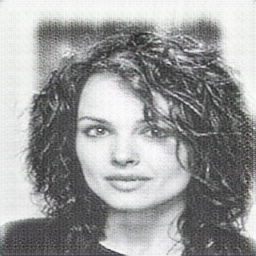

In [364]:
from IPython.display import Image
print(all_imgg2s[0])
print(all_orig_imgs[0])

file3 = open('../data/CelebA/text/16/162771.txt', 'r') 
text = []
Lines = file3.readlines() 
  
count = 0
# Strips the newline character 
for line in Lines: 
    text.append(line)
file3.close()
print(text)
Image(filename = all_orig_imgs[0])

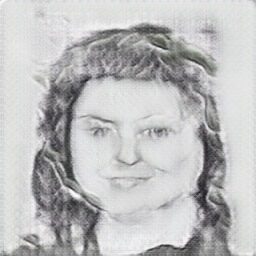

In [354]:
Image(filename = all_imgg2s[0])

../data/CelebA/images/162820_fake.png
['This old woman puts on lipstick with a smile.\n', 'The woman opening her mouth slightly has high cheekbones with a smile.\n', 'A woman has black hair with a smile.\n', 'This woman has high cheekbones and wears earrings.\n', 'The woman opening her mouth slightly has heavy makeup.\n', 'The old woman wears earrings.\n', 'This old woman has black hair with a smile.\n', 'The woman has black hair and wears heavy makeup with a smile.\n', 'A woman wears heavy makeup.\n', 'The old woman wear lipstick.\n']


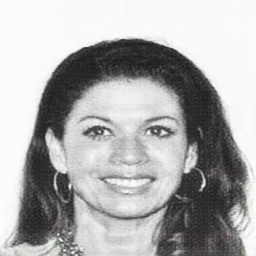

In [366]:
print(all_orig_imgs[49])
file3 = open('../data/CelebA/text/16/162820.txt', 'r') 
text = []
Lines = file3.readlines() 
  
count = 0
# Strips the newline character 
for line in Lines: 
    text.append(line)
file3.close()
print(text)
Image(filename = all_orig_imgs[49])

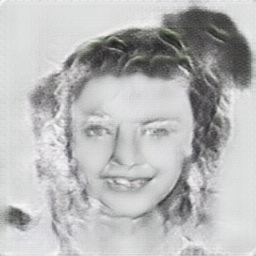

In [356]:
Image(filename = all_imgg2s[49])